# LSTM Regressor -- mean_temp

This model is used to predict mean_temp and input data of 90 days to predict the mean_temp one week ahead

Import library needed in the model

In [79]:
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Split the training set and test set

In [98]:
df=pd.read_csv('../dataset_for_analysis/data_weather_new1.csv',parse_dates=['date'])
df.set_index('date', inplace=True)

# Select the data used for model training
start_date='1990-01-01'
end_date='2020-12-31'
training_data=df[start_date:end_date]

X_mean_temp=training_data[['mean_temp','global_radiation']]

In [99]:
X_mean_temp

,mean_temp,global_radiation
date,,
1990-01-01,4.5,13.0
1990-01-02,5.2,13.0
1990-01-03,4.0,13.0
1990-01-04,5.3,31.0
1990-01-05,6.6,13.0
...,...,...
2020-12-27,7.5,32.0
2020-12-28,1.1,38.0
2020-12-29,2.6,21.0


Scaling the data

In [100]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler(feature_range=(-1,1))
scaled_mean_temp=scalar.fit_transform(X_mean_temp[['mean_temp']])

In [101]:
scaled_mean_temp

array([[-0.41764706],
       [-0.37647059],
       [-0.44705882],
       ...,
       [-0.52941176],
       [-0.52352941],
       [-0.72941176]])

In [102]:
timestep=90
X=[]
Y=[]
for i in range(len(X_mean_temp)-timestep-7):
    X.append(scaled_mean_temp[i:i+timestep])
    Y.append(scaled_mean_temp[i+timestep:i+timestep+7])

In [103]:
X=np.asanyarray(X)

In [104]:
Y=np.asanyarray(Y)

In [105]:
k1 = 10562
k2 = 10927
Xtrain = X[:k1,:,:]
Xtest = X[k1:k2,:,:]
X2020 = X[k2:,:,:]
Ytrain = Y[:k1]
Ytest= Y[k1:k2]
Y2020 = Y[k2:]

In [106]:
Xtrain.shape

(10562, 90, 1)

In [107]:
Ytrain.shape

(10562, 7, 1)

In [108]:
Xtest.shape

(365, 90, 1)

In [109]:
Ytest.shape

(365, 7, 1)

In [110]:
X2020.shape

(299, 90, 1)

In [111]:
Y2020.shape

(299, 7, 1)

In [112]:
Y2020

array([[[-0.23529412],
        [-0.27058824],
        [-0.32941176],
        ...,
        [-0.34705882],
        [-0.29411765],
        [-0.24117647]],

       [[-0.27058824],
        [-0.32941176],
        [-0.43529412],
        ...,
        [-0.29411765],
        [-0.24117647],
        [ 0.01764706]],

       [[-0.32941176],
        [-0.43529412],
        [-0.34705882],
        ...,
        [-0.24117647],
        [ 0.01764706],
        [-0.22352941]],

       ...,

       [[ 0.00588235],
        [ 0.02352941],
        [-0.32352941],
        ...,
        [-0.39411765],
        [-0.24117647],
        [-0.61764706]],

       [[ 0.02352941],
        [-0.32352941],
        [-0.52941176],
        ...,
        [-0.24117647],
        [-0.61764706],
        [-0.52941176]],

       [[-0.32352941],
        [-0.52941176],
        [-0.39411765],
        ...,
        [-0.61764706],
        [-0.52941176],
        [-0.52352941]]])

## Single output (predict one day ahead)

Create the instance of tensorboard to visualize the results

In [113]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir="../lstm_results/lstm_one_week_3")

In [114]:

# Initiate the model
model = Sequential()

# Define the input and convolution layer
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(90,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(7))

# Define the LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=100, return_sequences=True))

# Define the bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, activation='relu')))

# Define the dense and output layer
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mse', optimizer='adam')
history = model.fit(Xtrain,Ytrain,validation_data=(Xtest,Ytest), epochs=3, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/3
331/331 [==============================] - 33s 71ms/step - loss: 0.0306 - val_loss: 0.0219
Epoch 2/3
331/331 [==============================] - 22s 65ms/step - loss: 0.0267 - val_loss: 0.0237
Epoch 3/3
331/331 [==============================] - 21s 64ms/step - loss: 0.0256 - val_loss: 0.0238


Save the model

In [19]:
model.save('../lstm_results/lstm_one_week_mean_temp.hdf5')

### Module evaluation and results visualizaiton

In [20]:
from tensorflow.keras.models import load_model
model=load_model('../lstm_results/lstm_one_week_mean_temp.hdf5')

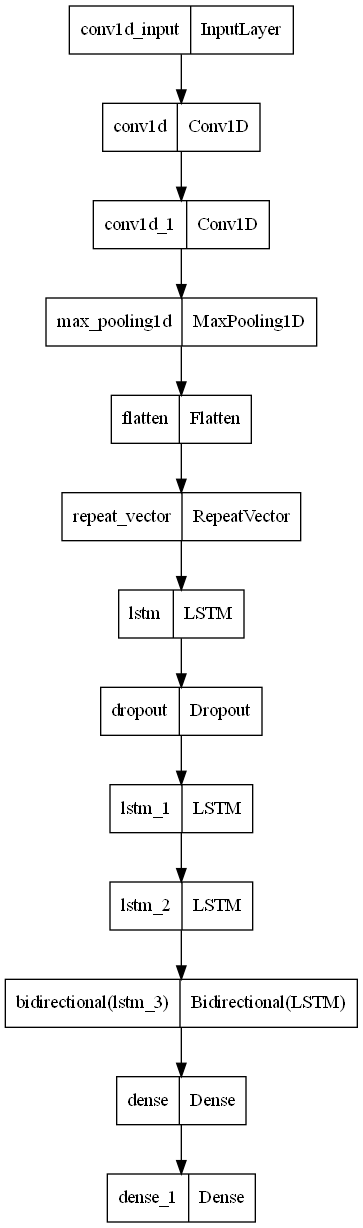

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [22]:
# Initiate the array of predicted result
predicted_result = np.zeros((299, 7, 1))

for day_idx in range(299):

    input_data = X2020[day_idx, :, :]
    daily_predictions = np.zeros((7, 1))

    # Predict the data in the next 7 days step by step
    for step in range(7):

        # Predict the result
        prediction = model.predict(input_data.reshape(1, 90, 1))

        # Add the result to the array
        daily_predictions[step] = prediction[0, 0]

        # Update the input
        input_data = np.roll(input_data, shift=-1)  # Shift the window to the left as the input
        input_data[-1, 0] = prediction[0, 0]  # Update the time step

    predicted_result[day_idx, :, :] = daily_predictions


1/1 [==============================] - 0s 56ms/step


In [23]:
predicted_result.shape

(299, 7, 1)

In [24]:
# get the original values of Y2020 and predicted result
Y2020_flattened = Y2020.reshape(-1, 1)
Y2020_original = scalar.inverse_transform(Y2020_flattened)
Y2020 = Y2020_original.reshape(299, 7, 1)

predicted_result_flattened = predicted_result.reshape(-1, 1)
predicted_result_original = scalar.inverse_transform(predicted_result_flattened)
predicted_result = predicted_result_original.reshape(299, 7, 1)

In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error

mse_list = []

for i in range(predicted_result.shape[0]):
    mse_i = mean_squared_error(Y2020[i], predicted_result[i])
    mse_list.append(mse_i)

average_mse = np.mean(mse_list)

print("MSE of mean_temp:", average_mse)
print(mse_list)


MSE of mean_temp: 10.220102153938766
[17.848462945778056, 12.722292115616414, 11.711406783017495, 6.35182206771007, 3.1875356595604845, 3.3087814605737487, 3.6730015976905093, 3.771815788061411, 2.4764747508608442, 2.7720239350714455, 3.2425093935198, 3.5460803185373457, 4.776564985417493, 5.970704045145371, 9.376189857506057, 12.485436987530694, 12.191507825564518, 14.709715309693406, 19.430368890040445, 12.833208360457002, 16.094885960302527, 14.31868590620134, 18.43095602441083, 22.73889127390766, 23.558122027579874, 27.893294106107504, 26.693431533044947, 23.355720797727987, 21.42737193587461, 8.974195700158894, 8.836544204366126, 7.489517994480198, 18.479044988873692, 24.048049071484815, 19.886693812001244, 26.46558955832476, 22.45802014875477, 19.866797238953474, 21.531061791933848, 12.42758959249039, 10.858126334160872, 8.416999731054975, 6.1973528674977745, 5.5580902518084585, 3.443994014087573, 0.955724253771024, 0.834766680520929, 0.7935530349968047, 0.8374657149424403, 1.100

In [44]:
Y2020[47]

array([[11.9],
       [11.3],
       [12.4],
       [12.1],
       [13.5],
       [14.3],
       [15.3]])

In [43]:
predicted_result[47]

array([[12.37650866],
       [12.58357703],
       [13.05929979],
       [13.49423598],
       [13.66178799],
       [13.92848921],
       [14.23347529]])

Mean_temp

Show the predicted result of one week

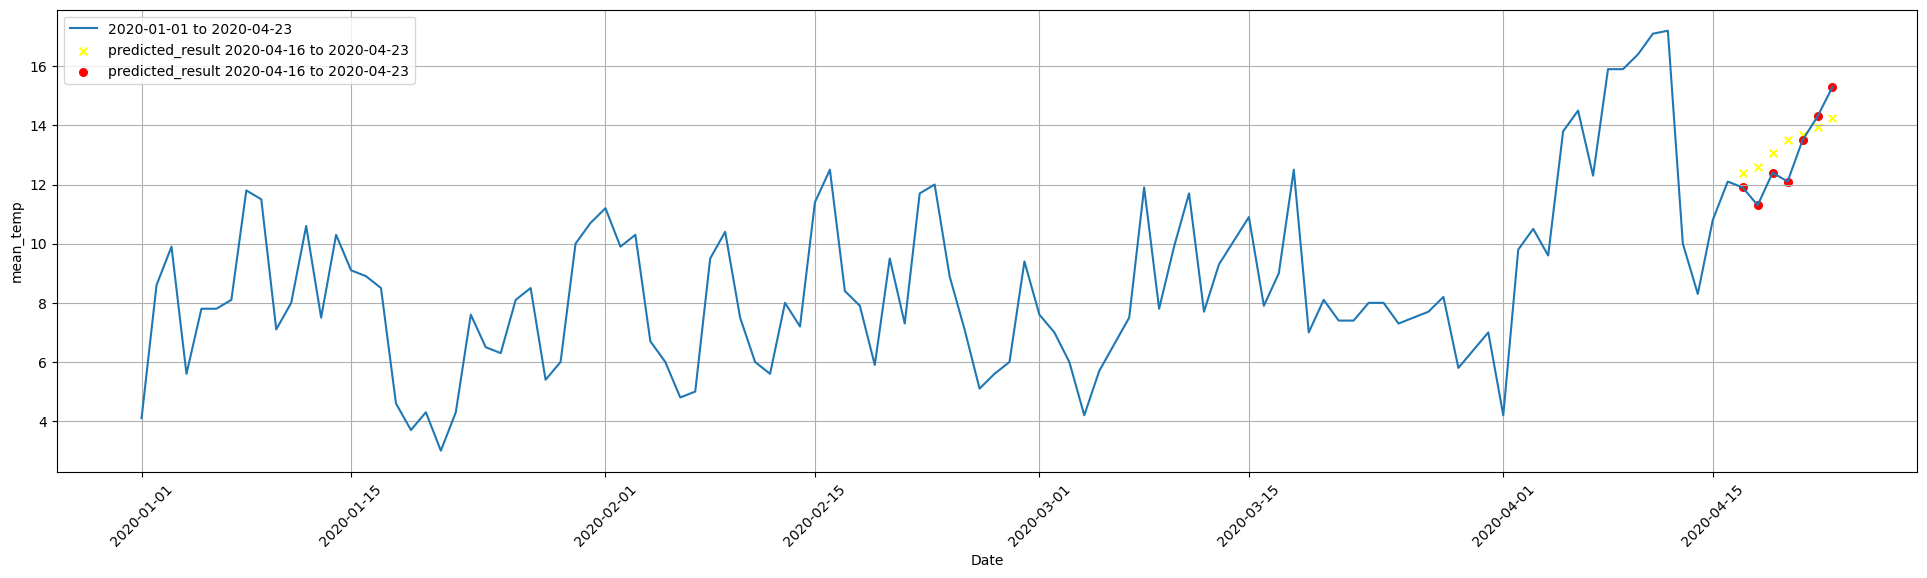

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# dates on x-axis
dates = pd.date_range(start='2020-01-01', end='2020-04-23', freq='D')

# get mean_temp values
mean_temp_data = df['2020-01-01':'2020-04-23']['mean_temp'].values

mean_temp_0101_to_0416 = mean_temp_data[-106:]
mean_temp_0417_to_0423 = mean_temp_data[-7:]

# create the plot
plt.figure(figsize=(24, 6))

plt.plot(dates, mean_temp_data, label='2020-01-01 to 2020-04-23', linestyle='-')
plt.scatter(dates[-7:], predicted_result[47], label='predicted_result 2020-04-16 to 2020-04-23', color='yellow', marker='x', s=30)
plt.scatter(dates[-7:], Y2020[47], label='predicted_result 2020-04-16 to 2020-04-23', color='red', marker='o', s=30)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('mean_temp')
plt.legend()
plt.grid(True)

# show the plot
plt.show()